In [1]:
"""
Politecnico di Torino - Laurea Triennale Ingegneria Energetica
Corso Energetica e Fonti Rinnovabili - Esercitazione Solare Termico
"""
__author__ = "Daniele Salvatore Schiera"
__version__ = "Rev. 25/03/2025"
__email__ = "daniele.schiera@polito.it"

# Imports
interactive = True
if interactive:
# for interactivity:
    %matplotlib widget 
else:
# for printing pdf:
    %matplotlib inline 

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from pvlib import solarposition, location
from IPython.display import Markdown, Image, display, HTML, Latex, IFrame
import ipywidgets as wds
#plt.style.use('seaborn-whitegrid')

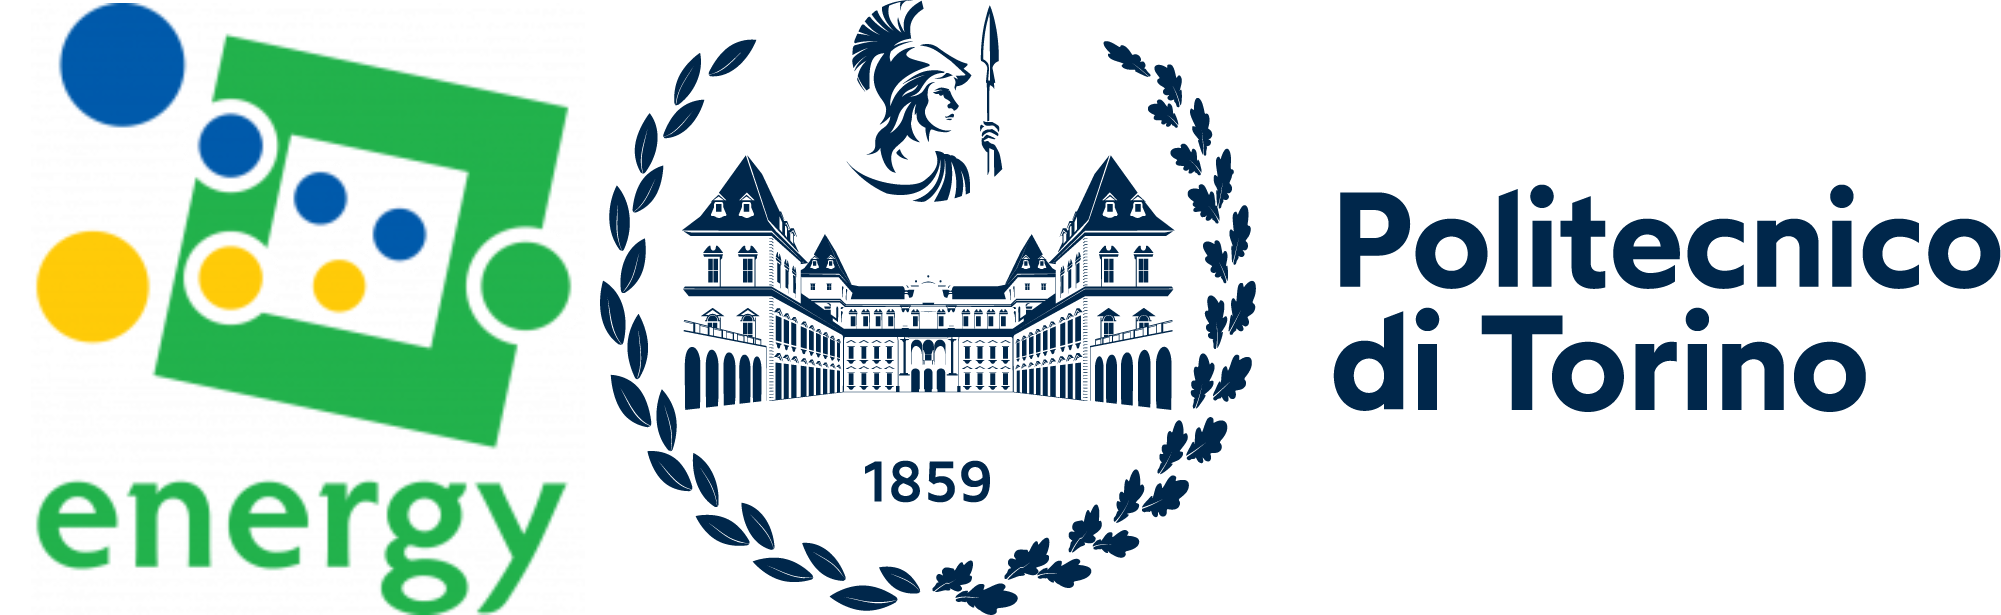

In [2]:
Image(filename="img/DENERG-Polito_Logo.png", width=400)

## Energetica e Fonti Rinnovabili
### DENERG Politecnico di Torino
#### Daniele Salvatore Schiera, PhD
#### daniele.schiera@polito.it

----

# Esercitazione - Solare Termico

## Obiettivi di apprendimento
- Impostare il bilancio termico di un collettore solare piano e tracciare la sua curva di efficienza. Individuare le condizioni di stagnazione termica del collettore.
- Utilizzare le curve di efficienza ricavate dalle prove standard sui collettori.

## Esercizi

1. È dato un collettore solare piano ad acqua avente una superficie vetrata di area $A_c = 1.5 \ m^2$, di cui sono note le proprietà ottiche $\tau\alpha = 0.8$ e il coefficiente globale di dispersione termica $U_c = 3.6 \ W/m^2/K$. Il collettore è attraversato da una portata di $60 \ kg/h$ di acqua glicolata ($cp = 3800 \ J/kg/K$) che entra nel collettore a $40 \ ^{{\circ}}C$, e quando il flusso radiativo solare incidente sul pannello è pari a $I_c = 800 \ W/m^2$ e la temperatura esterna dell’ambiente è pari a $15 \ ^{{\circ}}C$, in condizioni stazionarie viene misurata una temperatura di uscita dell’acqua dal collettore pari a $50 \ ^{{\circ}}C$. 

Determinare:

1. la potenza termica utile ceduta all’acqua;
2. l’efficienza del collettore nelle condizioni date;
3. il fattore di rimozione del collettore solare;
4. l’equazione dell’efficienza (supponendola lineare) del collettore in funzione della temperatura ridotta $T^* = (T_{f,i} – T_a)/I_c$ e tracciarne il grafico;
5. verificare il bilancio termico del collettore esplicitando le perdite (i.e., verificare che le perdite corrispondano alla differenza tra potenza solare entrante e potenza utile trasferita all’acqua);
6. calcolare la temperatura dell’acqua nel collettore in condizioni di efficienza nulla quando $I_c = 1000 \ W/m^2$ e $T_a = 30 \ ^{{\circ}}C$ (stagnazione del collettore).

2. Sono dati due collettori solari termici le cui curve di efficienza riportate nelle schede tecniche sono delle funzioni quadratiche della temperatura ridotta x, definita utilizzando la temperatura media del fluido nel collettore: $x = (T_m - T_a)/I_c$ secondo la forma: $\eta=\eta_0-a_1 x-a_1 x^2 I_c$. I coefficienti delle curve di efficienza riportati nelle schede tecniche dei due collettori sono i seguenti:
 
    *Collettore piano vetrato (P.V.)*: $\eta_0 = 0.72$; $a_1 = 3.8 \ W/(K\cdot m^2)$; $a_2 = 0.01 \ W/(K^2\cdot m^2)$ 

    *Collettore a tubi sottovuoto (C.S.T)*: $\eta_0 = 0.594$; $a_1 = 1.4 \ W/(K\cdot m^2)$; $a_2 = 0.007 \ W/(K^2\cdot m^2)$

    Calcolare per quale valore di temperatura esterna i due collettori si trovano ad operare con la stessa efficienza ipotizzando che entrambi operino con una temperatura media del fluido di $T_m = 50 \ ^{{\circ}}C$ quando il flusso di radiazione solare incidente è pari a $I_c = 800 \ W/m^2$.


In [3]:
display(Latex(r"\newpage"))

<IPython.core.display.Latex object>

# Esercizio 1
È dato un collettore solare piano ad acqua avente una superficie vetrata di area $A_c = 1.5 \ m^2$, di cui sono note le proprietà ottiche $\tau\alpha = 0.8$ e il coefficiente globale di dispersione termica $U_c = 3.6 \ W/m^2/K$. Il collettore è attraversato da una portata di $60 \ kg/h$ di acqua glicolata ($cp = 3800 \ J/kg/K$) che entra nel collettore a $40 \ ^{{\circ}}C$, e quando il flusso radiativo solare incidente sul pannello è pari a $I_c = 800 \ W/m^2$ e la temperatura esterna dell’ambiente è pari a $15 \ ^{{\circ}}C$, in condizioni stazionarie viene misurata una temperatura di uscita dell’acqua dal collettore pari a $50 \ ^{{\circ}}C$. 

Determinare:

1. la potenza termica utile ceduta all’acqua;
2. l’efficienza del collettore nelle condizioni date;
3. il fattore di rimozione del calore del collettore solare;
4. l’equazione dell’efficienza (supponendola lineare) del collettore in funzione della temperatura ridotta $T^* = (T_{f,i} – T_a)/I_c$ e tracciarne il grafico;
5. verificare il bilancio termico del collettore esplicitando le perdite (i.e., verificare che le perdite corrispondano alla differenza tra potenza solare entrante e potenza utile trasferita all’acqua);
6. calcolare la temperatura dell’acqua nel collettore in condizioni di efficienza nulla quando $I_c = 1000 \ W/m^2$ e $T_a = 30 \ ^{{\circ}}C$ (stagnazione del collettore).

## Dati

In [4]:
# Dati input
A_c = 1.5 # [m2]
ta = 0.8 # tau*alpha proprietà ottiche del collettore (alpha - assorbanza dell'assorbitore, tau - trasmittanza delle covers)
U_c = 3.6 # [W/m2/K]
m = 60 # [kg/h]
cp = 3800 # [J/kg/K]
T_fi = 40 # [°C] T fluido entrante
T_a = 15 # [°C] T ambiente
T_fo = 50 # [°C] T fluido uscente
I_c = 800 # [W/m2] radiazione incidente al pannello
# condizioni stazionarie
Markdown(fr'$A_c = {round(A_c,2)} \ m^2$; $\tau \alpha = {round(ta,2)}$; $U_c = {round(U_c,2)} \ W/m^2/K$; $\dot{{m}} = {round(m,2)} \ kg/h$; $cp = {round(cp,2)} \ J/kg/K$; $T_a = {round(T_a,2)} \ ^\circ C$; $T_{{f,i}} = {round(T_fi,2)} \ ^\circ C$; $T_{{f,o}} = {round(T_fo,2)} \ ^\circ C$; $I_c = {round(I_c,2)} \ W/m^2$.')

$A_c = 1.5 \ m^2$; $\tau \alpha = 0.8$; $U_c = 3.6 \ W/m^2/K$; $\dot{m} = 60 \ kg/h$; $cp = 3800 \ J/kg/K$; $T_a = 15 \ ^\circ C$; $T_{f,i} = 40 \ ^\circ C$; $T_{f,o} = 50 \ ^\circ C$; $I_c = 800 \ W/m^2$.

## Procedimento

È possibile valutare le prestazioni termiche di qualsiasi tipo di collettore solare termico da un bilancio energetico che determina la quota parte della radiazione incidente fornita come energia utile al fluido di lavoro. Per un collettore piano di
area $𝐴_𝑐$, il **bilancio energetico sulla piastra dell'assorbitore** è:
$$\begin{align*}
Q_a &= Q_u+Q_l+\frac{dE}{dt} \quad [W]\\
\text{dove:}\\
Q_a = I_c A_c \tau \alpha &\ \ \text{flusso termico assorbito dalla piastra.} \ Q_c=I_c A_c \ \text{potenza termica incidente sul collettore.} \\
Q_u &\ \ \text{flusso di scambio termico dal collettore-assorbitore al fluido di lavoro} \\
Q_l &\ \ \text{flusso di scambio termico (o perdita di calore) dalla piastra collettore-assorbitore all'ambiente circostante} \\
\frac{dE}{dt} &\ \ \text{rateo di accumulo di energia interna nella piastra}
\end{align*}$$

La **potenza termica utile** $Q_u$  ceduta all'acqua si determina applicando il bilancio termico al fluido che attraversa il collettore (in condizioni stazionarie): 
$$Q_u = \dot{m}c_p(T_{f,o}-T_{f,i}) \quad [W]$$

>**Nota**: nelle formule verificare sempre che le unità di misura siano coerenti ed eventualmente effettuare le dovute conversioni. Ad esempio, in questo caso: $\dot{m} \left [\frac{kg}{h} \right ]\cdot \frac{1}{3600}\left [\frac{h}{s} \right]= \dot{m} \left [\frac{kg}{s} \right]$; $c_p\left [\frac{J}{kg\cdot K} \right]$; $\Delta T [^\circ C \ o \ K]$.

In [5]:
Q_u = m/3600*cp*(T_fo-T_fi)
Markdown(fr'Svolgendo i calcoli otteniamo $Q_u = {round(Q_u,2)} \ W$.')

Svolgendo i calcoli otteniamo $Q_u = 633.33 \ W$.

La **potenza termica dispersa** $Q_l$, o perdita di calore, dalla piastra all'ambiente si determina attraverso la seguente relazione ($T_{m}$ è la temperatura media della piastra):
$$Q_l = U_cA_c(T_{m}-T_a) \quad [W]$$

L’**efficienza** del collettore $\eta_c$ viene calcolata come rapporto tra l’effetto utile e la potenza termica solare incidente sul collettore ($Q_c=A_cI_c$):
$$\eta_c = \frac{Q_u}{I_c A_c}$$

In [6]:
eta_c = Q_u/(I_c*A_c)
Markdown(fr'Svolgendo i calcoli otteniamo $\eta_c = {round(eta_c,2)}$.')

Svolgendo i calcoli otteniamo $\eta_c = 0.53$.

Il **fattore di rimozione del calore** (o *heat-removal factor*) $F_R$ è definito come il rapporto tra il guadagno utile ed il guadagno teorico che si otterrebbe se la temperatura del fluido termovettore lungo i tubi del collettore si mantenesse sempre alla stessa temperatura di ingresso, cioè quindi alla minima differenza di temperatura tra l'assorbitore e l'ambiente. Dunque possiamo esprimere come: 
$$\begin{align*}
F_R &= \frac{Q_u}{A_c[I_c \tau \alpha - U_c(T_{f,i}-T_a)]}\\
\text{dove:}\\
I_c\tau\alpha &\ \ \text{radiazione assorbita dalla piastra}\\
U_c &\ \ \text{coefficiente di scambio termico globale} \ [W/m^2/K]
\end{align*}$$

In [7]:
F_R = Q_u/(A_c*(I_c*ta-U_c*(T_fi-T_a)))
Markdown(f'Svolgendo i calcoli otteniamo $F_R = {round(F_R,3)}$.')

Svolgendo i calcoli otteniamo $F_R = 0.768$.

Possiamo scrivere l'efficienza in forma lineare in funzione della temperatura ridotta $x = T^*=\frac{T_{f,i}-T_a}{I_c}$ utilizzando il fattore di rimozione del calore:
$$\eta_c = \frac{Q_u}{I_c A_c}=F_R \left [(\tau \alpha)-\frac{U_c(T_{f,i}-T_a)}{I_c}\right ]= F_R(\tau \alpha)-F_R U_c T^* = a - bx$$

In [8]:
a = F_R*ta
b = F_R*U_c
x = np.linspace(0,10,100)
eta_c_func = lambda x: a-b*x
Markdown(fr'I coeffienti avranno i seguenti valori: $a = F_R(\tau \alpha) =  {round(a,3)} $; $b = F_R U_c =  {round(b,3)} \ W/m^2/K$.')

I coeffienti avranno i seguenti valori: $a = F_R(\tau \alpha) =  0.614 $; $b = F_R U_c =  2.764 \ W/m^2/K$.

Il grafico dell'efficienza in funzione di x è il seguente:

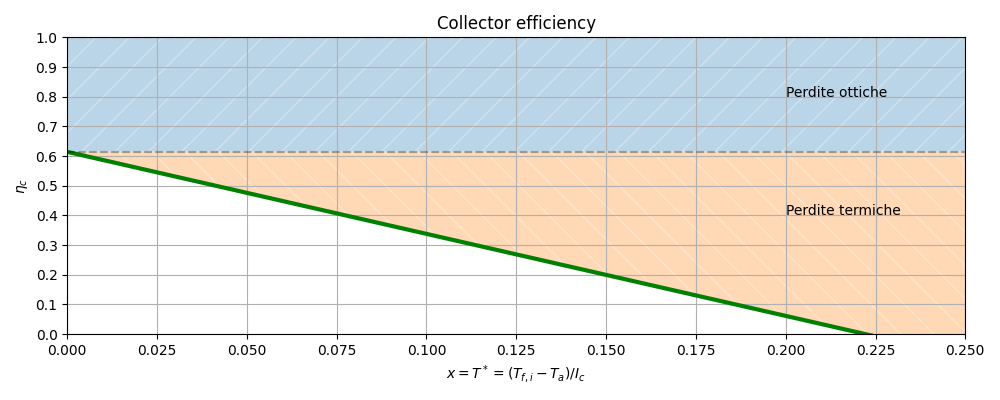

In [9]:
fig, ax = plt.subplots(1,1,figsize=(10, 4))
fig.canvas.header_visible = False
ax.plot(x,eta_c_func(x),c='g',linewidth=3)
ax.axhline(1,linestyle='--', c='k')
ax.axhline(a,linestyle='--', c='k',alpha=0.3)
ax.fill_between(x,1,a, alpha=0.3,hatch='/', edgecolor='white')
ax.fill_between(x,eta_c_func(x),a, alpha=0.3,hatch='\\', edgecolor='white')
ax.text(0.20,0.8,'Perdite ottiche')
ax.text(0.20,0.4,'Perdite termiche')
ax.set_title('Collector efficiency')
ax.set_xlabel(r'$x = T^*=(T_{f,i}-T_a)/I_c$')
ax.set_ylabel(r'$\eta_c$')
ax.set_ylim([0,1])
ax.set_xlim([0,0.25])
ax.set_xticks(np.arange(0, 0.25+0.025, 0.025))
ax.set_yticks(np.arange(0, 1+0.1, 0.1))
ax.grid('on')
plt.tight_layout()

Per esplicitare le perdite del collettore $Q_l$, scriviamo il **bilancio termico questa volta al collettore** (in condizioni stazionarie) in funzione della potenza solare incidente sul collettore $Q_c=A_cI_c$ e la potenza utile trasferita all’acqua $Q_u$:
$$\begin{align*}
Q_c= Q_u+Q_l \rightarrow  Q_l &= Q_c-Q_u = A_c I_c - [F_R A_c I_c \tau \alpha -F_R A_c U_c(T_{f,i}-T_a)] \quad [W]\\
Q_l &= Q_c-Q_u = Q_c (1-F_R \tau \alpha)+ F_R A_c U_c(T_{f,i}-T_a) \quad [W]\\
&\text{dove:}\\
&Q_c (1-F_R \tau \alpha): \text{perdite ottiche} \\
& F_R A_c U_c(T_{f,i}-T_a):\text{perdite termiche}
\end{align*}$$

In [10]:
thermal_loss = F_R*A_c*U_c*(T_fi-T_a)
Q_c = A_c * I_c
optical_loss = Q_c*(1-F_R*ta)
Q_l = optical_loss+thermal_loss
Q_l2 = Q_c-Q_u
Markdown(fr'Le perdite ottiche risultano ${round(optical_loss,2)} \ W$ mentre le perdite termiche risultano ${round(thermal_loss,2)} \ W$ per un totale di perdite $Q_l = {round(optical_loss+thermal_loss,2)} \ W$. Per verifica, risulta $Q_c-Q_u={round(Q_l2,2)} \ W$.')

Le perdite ottiche risultano $463.03 \ W$ mentre le perdite termiche risultano $103.64 \ W$ per un totale di perdite $Q_l = 566.67 \ W$. Per verifica, risulta $Q_c-Q_u=566.67 \ W$.

La stagnazione del collettore corrisponde alle condizioni di efficienza nulla, quando la potenza termica utile è nulla, cioè in assenza di circolazione del fluido termovettore non viene più smaltita la potenza termica assorbita dal collettore, provocando così un aumento della temperatura del fluido. Solitamente la temperatura per cui si verifica la stagnazione viene definita in condizioni di riferimento $I_c = 1000 \ W/m^2$ e $T_a = 30 ^\circ C$.
L'efficienza del collettore è nulla quando:
$$\eta_c = 0 \implies a-bx=0 \rightarrow x = \frac{a}{b}$$

In [25]:
I_c_stgn = 1000
T_a_stgn = 30
stagnazione = a/b
Markdown(fr'Dunque, risulta $x={round(stagnazione,3)}$.')

Dunque, risulta $x=0.222$.

In [26]:
T_ft_stagn = stagnazione*I_c_stgn+T_a_stgn
Markdown(fr'Ricordando che $x = T^*=(T_{{f,i}}-T_a)/I_c \rightarrow T_{{f,i}}={round(T_ft_stagn,2)} \ ^\circ C$.')

Ricordando che $x = T^*=(T_{f,i}-T_a)/I_c \rightarrow T_{f,i}=252.22 \ ^\circ C$.

In [13]:
stagnazione

0.2222222222222222

In [14]:
display(Latex(r"\newpage"))

<IPython.core.display.Latex object>

# Esercizio 2
Sono dati due collettori solari termici le cui curve di efficienza riportate nelle schede tecniche sono delle funzioni quadratiche della temperatura ridotta x, definita utilizzando la temperatura media del fluido nel collettore: $x = (T_m - T_a)/I_c$ secondo la forma: $\eta=\eta_0-a_1 x-a_2 x^2 I_c$. I coefficienti delle curve di efficienza riportati nelle schede tecniche dei due collettori sono i seguenti:
 
*Collettore piano vetrato (P.V.)*: $\eta_0 = 0.72$; $a_1 = 3.8 \ W/(K\cdot m^2)$; $a_2 = 0.01 \ W/(K^2\cdot m^2)$ 

*Collettore a tubi sottovuoto (C.S.T)*: $\eta_0 = 0.594$; $a_1 = 1.4 \ W/(K\cdot m^2)$; $a_2 = 0.007 \ W/(K^2\cdot m^2)$

Calcolare per quale valore di temperatura esterna $T_a$ i due collettori si trovano ad operare con la stessa efficienza ipotizzando che entrambi operino con una temperatura media del fluido di $T_m = 50 \ ^{{\circ}}C$ quando il flusso di radiazione solare incidente è pari a $I_c = 800 \ W/m^2$.

In [15]:
# Dati input
eta_0PV = 0.72
a_1PV = 3.8 
a_2PV = 0.01

eta_0CST=0.594
a_1CST = 1.4
a_2CST = 0.007

T_m = 50
I_c = 800
#funzioni
x = np.linspace(0,10,100000)
eta_pv = lambda x: eta_0PV-a_1PV*x-a_2PV*x**2*I_c
eta_cst = lambda x: eta_0CST-a_1CST*x-a_2CST*x**2*I_c

## Procedimento

Per le prove dei collettori in Europa, la norma UNI EN 12975 stabilisce la metodologia per la definizione delle curve di efficienza. Poichè la temperatura media della piastra $T_m$ (tra ingresso ed uscita dell'acqua) è di difficile misura, nelle prove sui collettori l'efficienza si può esprimere in funzione della temperatura ridotta, definita come:
$$x = \frac{T_m-T_a}{I_c}$$

e i valori sperimentali di efficienza vengono descritti attraverso una funzione quadratica di x:
$$\begin{align*}
\eta &=\eta_0 -a_1x-a_2x^2I_c\\
\text{dove:}\\
\eta_0 &\ \text{fattore di conversione} \ [-]\\
a_1 &\ \text{coefficiente di perdita lineare} \ W/m^2/K \\
a_2 &\ \text{coefficiente di perdita quadratico} \ W/m^2/K^2
\end{align*}$$

Seguendo la normativa ed utlizzando i dati tecnici dei due collettori possiamo scrivere l'efficienza come segue:
$$\eta_{PV} =\eta_{0,PV} -a_{1,PV}x-a_{2,PV}x^2I_c$$
$$\eta_{CST} =\eta_{0,CST} -a_{1,CST}x-a_{2,CST}x^2I_c$$

Di seguito il grafico delle curve di efficienza dei due collettori in funzione della temperatura ridotta:

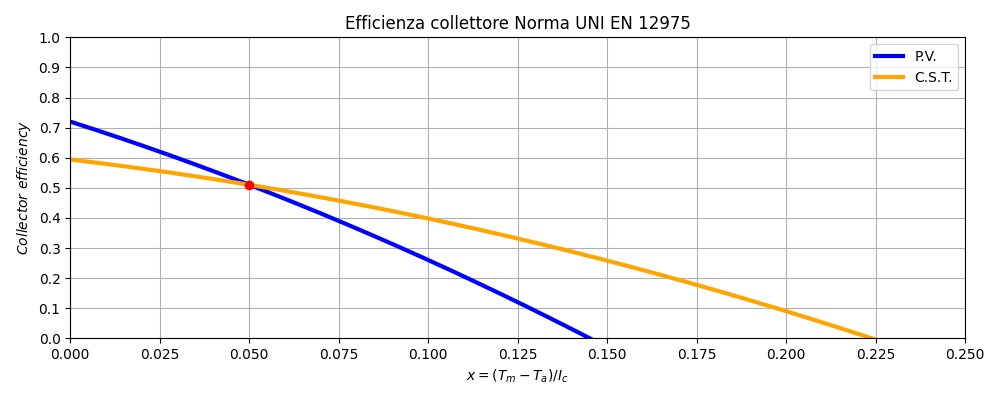

In [16]:
fig, ax = plt.subplots(1,1,figsize=(10, 4))
fig.canvas.header_visible = False
ax.plot(x,eta_pv(x),c='b',linewidth=3, label='P.V.')
ax.plot(x,eta_cst(x),c='orange',linewidth=3,label='C.S.T.')
ax.set_title('Efficienza collettore Norma UNI EN 12975')
ax.set_xlabel(r'$x =(T_m-T_a)/I_c$')
ax.set_ylabel(r'$Collector \ efficiency$')
ax.legend()
ax.set_ylim([0,1])
ax.set_xlim([0,0.25])
ax.set_xticks(np.arange(0, 0.25+0.025, 0.025))
ax.set_yticks(np.arange(0, 1+0.1, 0.1))
ax.grid('on')

xx = np.roots([-(a_2PV-a_2CST)*I_c,-(a_1PV-a_1CST), (eta_0PV-eta_0CST)])
x_final = xx.max()
ax.scatter(xx,eta_pv(xx),c='red',zorder=3)

plt.tight_layout()

Per calcolare la temperatura esterna in cui i due collettori avranno la stessa efficienza basterà eguagliare le equazioni precedenti e risolvere per x, al fine di trovare il punto di intersezione delle due curve:
$$\eta_{0,PV}-a_{1,PV}x-a_{2,PV}x^2I_c=\eta_{0,CST} -a_{1,CST}x-a_{2,CST}x^2I_c$$
$$(\eta_{0,PV}-\eta_{0,CST})-(a_{1,PV}-a_{1,CST})x-(a_{2,PV}-a_{2,CST})x^2I_c=0$$

Risolvendo l'equazione di secondo grado trovo due soluzioni. La soluzione negativa non ha senso fisico e dunque non è considerata.

In [17]:
Markdown(fr'$x = {round(x_final,5)}$, da cui si ricava la temperatura esterna $T_a = {round(T_m-x_final*I_c,2)}^\circ C$.')

$x = 0.05$, da cui si ricava la temperatura esterna $T_a = 10.0^\circ C$.

-------
Le versioni statiche ed aggiornate dei notebook le trovate online su [![GitHub](img/github.png)](https://github.com/DSSchiera/materials). 

Le versioni interattive dei notebook le trovate su [![Binder](img/binder_logo.png)](https://mybinder.org/v2/gh/DSSchiera/materials/HEAD).

In [18]:
sep = 'Rev.'
Markdown(f'Versione Documento: {__version__.split(sep)[1]}')

Versione Documento:  25/03/2025